In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import re
import seaborn as sns

# formatting
pd.options.display.float_format = '{:,}'.format
table_style = [{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana'),
            ("font-size", "90%")]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'), 
            ("font-size", "90%"),
            ("font-weight", "bold")]},
 {'selector': 'tr:hover',
  'props': [('background-color', '#ffffcc')]}
]

bench = {'cut_sgemm-0':0, 'cut_wmma-0': 0, 'parb_stencil-0': 1, 'parb_sgemm-0': 0,
        'parb_lbm-0': 1, 'parb_spmv-0': 1, 'parb_cutcp-0': 0}

def color_CM(s):
    '''
    color compute intensive green and memory intensive red
    '''
    if bench[s['benchmark']] == 0:
        # compute intensive
        return ['color: #5fba7d' for v in s]
    else:
        return ['color: #d65f5f' for v in s]
    
def color_CM_pair(s):
    return ['color: #5fba7d' if bench[v] == 0 else 'color: #d65f5f' for v in s]

def avg_array(s):
    result = [np.average(np.array(v[1:-1].split(' ')).astype(float)) for v in s]
    return result

# Isolated Stats

In [3]:
df = pd.read_csv('seq.csv')
df = df.drop(columns=['gpusim_version', 'jobId', 'config'])
df = df.rename(columns={'pair_str': 'benchmark'})
print(df.columns)

Index(['benchmark', 'grid_x', 'grid_y', 'grid_z', 'block_x', 'block_y',
       'block_z', 'ctas/SM', 'runtime', 'instructions', 'avg_mem_lat',
       'avg_core_to_l2', 'avg_l2_to_core', 'avg_mrq_latency',
       'stall_core_ldst', 'stall_icnt_to_l2', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'stall_l2_to_icnt', 'l1D_miss_rate',
       'l2_miss_rate', 'dram_bw'],
      dtype='object')


### Basics

In [4]:
df['grid'] = df['grid_x'] * df['grid_y'] * df['grid_z']
df['block'] = df['block_x'] * df['block_y'] * df['block_z']
# df['runtime'] = df['runtime'].astype(float)
df['achieved ctas/SM'] = pd.DataFrame([df['grid'] / 80, df['ctas/SM']]).min() 
df['avg_dram_bw'] = df['dram_bw'].transform(avg_array)


basic = df[['benchmark', 'grid', 'block', 'ctas/SM', 'achieved ctas/SM', 'runtime', 'instructions',
           'l1D_miss_rate', 'l2_miss_rate', 'avg_dram_bw']]


# style the table
basic.style.set_table_styles(table_style).hide_index()\
            .format({'runtime': "{:,}", 'instructions': '{:,}', 
                     'achieved ctas/SM': '{:.1f}', 
#                      'avg_dram_bw':'{:.2f}'
                    })\
            .apply(color_CM, axis=1)


# Observations:
# 1. spmv has a relatively high L1D cache hit rate. We should somehow give higher priority to spmv in L1D

benchmark,grid,block,ctas/SM,achieved ctas/SM,runtime,instructions,l1D_miss_rate,l2_miss_rate,avg_dram_bw
cut_sgemm-0,128,256,2,1.6,"91,668","228,392,960",1,0.5466,0.089183
parb_stencil-0,1024,128,16,12.8,"334,891","644,994,210",1,0.7651,0.738653
parb_sgemm-0,528,128,11,6.6,"654,458","2,800,545,792",0.9203,0.1445,0.0336707
parb_lbm-0,18000,120,12,12.0,"929,616","427,778,603",1,0.9996,0.669115
parb_spmv-0,1147,128,16,14.3,"73,031","52,720,795",0.5358,0.8571,0.774265
parb_cutcp-0,121,128,16,1.5,"525,052","7,055,002,292",1,0.0453,1.33333e-06
cut_wmma-0,128,64,4,1.6,"62,335","36,372,480",0.9957,0.1275,0.000294208


### Memory Latency

In [5]:
df['time(l2/dram)'] = df['avg_mem_lat'] - df['avg_core_to_l2'] - df['avg_l2_to_core']

l2_hit_lat = 120
dram_lat = 100
df['predict(l2/dram)'] = l2_hit_lat + dram_lat * df['l2_miss_rate']

mem = df[['benchmark', 'avg_mem_lat', 'avg_core_to_l2', 
          'avg_l2_to_core', 'avg_mrq_latency', 'time(l2/dram)', 'predict(l2/dram)']]


# style the table
mem.style.set_table_styles(table_style).hide_index()\
        .format({'avg_mem_lat': "{:,}", 'avg_core_to_l2':'{:,}'})\
        .apply(color_CM, axis=1)

benchmark,avg_mem_lat,avg_core_to_l2,avg_l2_to_core,avg_mrq_latency,time(l2/dram),predict(l2/dram)
cut_sgemm-0,315,150,22,6,143,174.66
parb_stencil-0,"1,277",694,20,170,563,196.51
parb_sgemm-0,223,32,11,15,180,134.45
parb_lbm-0,"21,834","21,115",58,187,661,219.96
parb_spmv-0,796,241,15,76,540,205.71
parb_cutcp-0,154,22,7,6,125,124.53
cut_wmma-0,836,704,8,8,124,132.75


### Stalls (per cycle)

In [6]:
stall = df[['stall_core_ldst', 'stall_icnt_to_l2', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'stall_l2_to_icnt']].div(df[['runtime']].iloc[:, 0], axis=0)

stall = pd.concat([df['benchmark'], stall], axis=1)

stall.style.set_table_styles(table_style) \
            .hide_index() \
            .format({'stall_core_ldst':'{:.1f}', 
                     'stall_icnt_to_l2':'{:.1f}', 
                     'l2_rshr_entry_fail':'{:.1f}', 
                     'l2_rshr_merge_fail':'{:.1f}'})\
            .apply(color_CM, axis=1)

benchmark,stall_core_ldst,stall_icnt_to_l2,l2_rshr_entry_fail,l2_rshr_merge_fail,stall_l2_to_icnt
cut_sgemm-0,5.8,0.3,0.0,0.2,0
parb_stencil-0,11.8,21.5,0.0,0.0,0
parb_sgemm-0,11.3,0.0,0.0,3.1,0
parb_lbm-0,9.2,19.6,0.0,0.0,0
parb_spmv-0,37.0,13.9,0.0,0.0,0
parb_cutcp-0,3.7,0.0,0.0,0.0,0
cut_wmma-0,13.6,0.2,0.0,0.0,0


# Shared

In [7]:
sdf = pd.read_csv('conc.csv')
sdf = sdf.drop(columns=['gpusim_version', 'jobId', 'config'])
sdf = sdf.rename(columns={'pair_str': 'benchmark'})


pair = [re.split(r'-(?=\D)', p) for p in sdf['benchmark']]
df_pair = pd.DataFrame(pair, columns=['1_bench', '2_bench'])
sdf = pd.concat([df_pair, sdf], axis=1)

first = pd.merge(sdf['1_bench'], df, right_on='benchmark', left_on='1_bench', how='left')
second = pd.merge(sdf['2_bench'], df, right_on='benchmark', left_on='2_bench', how='left')

print(sdf.columns)

Index(['1_bench', '2_bench', 'benchmark', '1_grid_x', '1_grid_y', '1_grid_z',
       '1_block_x', '1_block_y', '1_block_z', '1_ctas/SM', '1_runtime',
       '1_instructions', '1_avg_mem_lat', '1_avg_core_to_l2',
       '1_avg_l2_to_core', '1_avg_mrq_latency', '2_grid_x', '2_grid_y',
       '2_grid_z', '2_block_x', '2_block_y', '2_block_z', '2_ctas/SM',
       '2_runtime', '2_instructions', '2_avg_mem_lat', '2_avg_core_to_l2',
       '2_avg_l2_to_core', '2_avg_mrq_latency', 'stall_icnt_to_l2',
       'stall_l2_to_icnt', 'stall_core_ldst', 'l1D_miss_rate', 'l2_miss_rate',
       'runtime', 'l2_rshr_entry_fail', 'l2_rshr_merge_fail', 'dram_bw'],
      dtype='object')


## Basics

In [8]:
sdf['1_s_ctas/SM'] = pd.DataFrame([first['achieved ctas/SM'], sdf['1_ctas/SM']]).min()
sdf['2_s_ctas/SM'] = pd.DataFrame([second['achieved ctas/SM'], sdf['2_ctas/SM']]).min()

sdf['1_i_ctas/SM'] = first['achieved ctas/SM']
sdf['2_i_ctas/SM'] = second['achieved ctas/SM']

sdf['1_slowdown'] = first['runtime'].div(sdf['1_runtime'])
sdf['2_slowdown'] = second['runtime'].div(sdf['2_runtime'])

sdf['WS'] = sdf['1_slowdown'] + sdf['2_slowdown']

sdf['avg_dram_bw'] = sdf['dram_bw'].transform(avg_array)

s_basic = sdf[['1_bench', '2_bench',
               '1_s_ctas/SM', '1_i_ctas/SM',
                '2_s_ctas/SM', '2_i_ctas/SM',
               'l1D_miss_rate',
               '1_slowdown', '2_slowdown',
               'WS', 'avg_dram_bw']]

def mark_high_slowdown(s):
    return ['background-color: yellow' if v < 0.5 else '' for v in s]

s_basic.style.set_table_styles(table_style)\
            .hide_index()\
            .apply(color_CM_pair, axis=0, subset=['1_bench', '2_bench'])\
            .format({'1_slowdown':'{:.2f}', '2_slowdown':'{:.2f}', 'WS':'{:.2f}'})\
            .apply(mark_high_slowdown, axis=0, subset=['1_slowdown', '2_slowdown'])

#TODO: figure out how to deal with elastic ctas/SM and pricing

1_bench,2_bench,1_s_ctas/SM,1_i_ctas/SM,2_s_ctas/SM,2_i_ctas/SM,l1D_miss_rate,1_slowdown,2_slowdown,WS,avg_dram_bw
parb_cutcp-0,parb_spmv-0,1.5125,1.5125,8,14.3375,0.5391,0.93,1.04,1.97,0.811218
parb_sgemm-0,parb_spmv-0,6,6.6,7,14.3375,0.6032,0.37,0.93,1.31,0.772888
parb_sgemm-0,parb_stencil-0,6,6.6,7,12.8,0.987,0.28,0.88,1.17,0.686522
cut_wmma-0,parb_spmv-0,1.6,1.6,8,14.3375,0.5904,0.61,0.76,1.36,0.677667
cut_wmma-0,parb_stencil-0,1.6,1.6,8,12.8,0.985,0.45,0.60,1.05,0.52345
parb_cutcp-0,parb_stencil-0,1.5125,1.5125,8,12.8,0.9985,0.78,0.97,1.75,0.722368
parb_cutcp-0,parb_lbm-0,1.5125,1.5125,6,12,1,0.73,1.03,1.75,0.430781
cut_wmma-0,parb_lbm-0,1.6,1.6,6,12,0.9944,0.27,0.75,1.02,0.538619
parb_sgemm-0,parb_lbm-0,6,6.6,6,12,0.9966,0.08,1.01,1.09,0.669319
cut_sgemm-0,cut_wmma-0,1,1.6,1.6,1.6,0.9576,0.60,0.87,1.48,0.160384


## Memory latency

In [9]:
sdf['1_lat'] = sdf['1_avg_mem_lat'].div(first['avg_mem_lat'])
sdf['2_lat'] = sdf['2_avg_mem_lat'].div(second['avg_mem_lat'])

sdf['1_core_to_l2'] = sdf['1_avg_core_to_l2'].div(first['avg_core_to_l2'])
sdf['2_core_to_l2'] = sdf['2_avg_core_to_l2'].div(second['avg_core_to_l2'])

sdf['1_l2_to_core'] = sdf['1_avg_l2_to_core'].div(first['avg_l2_to_core'])
sdf['2_l2_to_core'] = sdf['2_avg_l2_to_core'].div(second['avg_l2_to_core'])

sdf['1_l2_to_core'] = sdf['1_avg_l2_to_core'].div(first['avg_l2_to_core'])
sdf['2_l2_to_core'] = sdf['2_avg_l2_to_core'].div(second['avg_l2_to_core'])

sdf['1_mrq'] = sdf['1_avg_mrq_latency'].div(first['avg_mrq_latency'])
sdf['2_mrq'] = sdf['2_avg_mrq_latency'].div(second['avg_mrq_latency'])

print('Relative increase (shared / isolated):')

s_mem = sdf[['1_bench',
             '1_lat',
             '1_core_to_l2',
             '1_l2_to_core',
             '1_mrq',
             '2_bench',
             '2_lat',
             '2_l2_to_core',
             '2_core_to_l2',
             '2_mrq',
            ]]

s_mem.style.set_table_styles(table_style)\
        .hide_index()\
        .apply(color_CM_pair, axis=0, subset=['1_bench', '2_bench'])\
        .format({'1_lat':'{:.2f}', '2_lat':'{:.2f}', 
                 '1_core_to_l2':'{:.2f}', '2_core_to_l2':'{:.2f}',
                 '1_l2_to_core':'{:.2f}', '2_l2_to_core':'{:.2f}',
                 '1_mrq':'{:.2f}', '2_mrq':'{:.2f}',
                })

Relative increase (shared / isolated):


1_bench,1_lat,1_core_to_l2,1_l2_to_core,1_mrq,2_bench,2_lat,2_l2_to_core,2_core_to_l2,2_mrq
parb_cutcp-0,2.18,3.86,4.71,13.67,parb_spmv-0,0.68,1.87,0.35,1.08
parb_sgemm-0,2.05,4.03,1.91,5.93,parb_spmv-0,0.60,1.53,0.37,0.84
parb_sgemm-0,2.17,2.84,1.55,10.73,parb_stencil-0,0.32,1.00,0.11,0.90
cut_wmma-0,2.23,0.77,141.62,9.50,parb_spmv-0,0.94,10.93,1.06,0.76
cut_wmma-0,2.08,1.31,72.12,16.88,parb_stencil-0,0.94,4.00,1.11,0.81
parb_cutcp-0,2.74,4.86,4.71,30.33,parb_stencil-0,0.39,1.00,0.11,0.98
parb_cutcp-0,13.10,73.59,6.14,31.83,parb_lbm-0,0.44,0.69,0.43,1.01
cut_wmma-0,3.21,3.32,12.50,16.25,parb_lbm-0,0.66,0.88,0.65,0.93
parb_sgemm-0,11.92,64.50,4.00,11.73,parb_lbm-0,0.45,0.86,0.44,1.00
cut_sgemm-0,3.22,5.21,4.00,5.33,cut_wmma-0,1.02,33.38,0.63,1.25


## Stalls (per cycle)

In [10]:
s_stall = sdf[['stall_core_ldst', 'stall_icnt_to_l2', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'stall_l2_to_icnt']].div(sdf[['runtime']].iloc[:, 0], axis=0)

s_stall = pd.concat([sdf[['1_bench', '2_bench']], s_stall], axis=1)

s_stall.style.set_table_styles(table_style).hide_index()\
        .apply(color_CM_pair, axis=0, subset=['1_bench', '2_bench'])\
        .format({'stall_core_ldst':'{:.2f}', 'stall_icnt_to_l2':'{:.2f}', 'l2_rshr_entry_fail':'{:.2f}',
       'l2_rshr_merge_fail':'{:.2f}', 'stall_l2_to_icnt':'{:.2f}'})
 


1_bench,2_bench,stall_core_ldst,stall_icnt_to_l2,l2_rshr_entry_fail,l2_rshr_merge_fail,stall_l2_to_icnt
parb_cutcp-0,parb_spmv-0,30.86,6.80,0.00,0.41,0.00
parb_sgemm-0,parb_spmv-0,30.74,5.53,0.04,4.98,0.00
parb_sgemm-0,parb_stencil-0,13.01,6.72,0.00,2.37,0.00
cut_wmma-0,parb_spmv-0,34.05,7.54,0.00,0.21,0.00
cut_wmma-0,parb_stencil-0,15.83,4.48,0.00,1.34,0.00
parb_cutcp-0,parb_stencil-0,11.74,6.25,0.00,0.04,0.00
parb_cutcp-0,parb_lbm-0,6.14,13.08,0.00,0.01,0.00
cut_wmma-0,parb_lbm-0,12.29,9.74,0.00,0.74,0.00
parb_sgemm-0,parb_lbm-0,9.76,22.03,0.01,0.20,0.00
cut_sgemm-0,cut_wmma-0,14.89,0.91,0.00,0.72,0.00


# LBM

In [11]:
ldf = pd.read_csv('lbm-hop.csv')
print(ldf.columns)

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'grid_x', 'grid_y',
       'grid_z', 'block_x', 'block_y', 'block_z', 'ctas/SM', 'runtime',
       'instructions', 'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
       'avg_mrq_latency', 'stall_core_ldst', 'stall_icnt_to_l2',
       'l2_rshr_entry_fail', 'l2_rshr_merge_fail', 'stall_l2_to_icnt',
       'l1D_miss_rate', 'l2_miss_rate', 'packet_lat_out', 'network_lat_out',
       'inject_out', 'accepted_out', 'packet_lat_in', 'network_lat_in',
       'inject_in', 'accepted_in', 'dram_bw', 'row_buffer_locality', 'mrqq'],
      dtype='object')


In [12]:
ldf['CTA/SM'] = ldf['config'].apply(lambda x: x[7:-3]).astype(int)
ldf['avg_dram_bw'] = ldf['dram_bw'].transform(avg_array)
ldf['avg_row_locality'] = ldf['row_buffer_locality'].transform(avg_array)
ldf['avg_mrqq'] = ldf['mrqq'].transform(avg_array)
ldf['stall_l2'] = ldf['stall_icnt_to_l2'].div(ldf['runtime']) / 44
ldf['stall_ldst'] = ldf['stall_core_ldst'].div(ldf['runtime'])

l_basic = ldf[['pair_str', 'CTA/SM', 
               'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core', 'avg_mrq_latency', 
               'stall_l2', 'stall_ldst',
               'avg_dram_bw', 'avg_row_locality', 'avg_mrqq',
               'runtime', 'instructions',
               'packet_lat_out', 'network_lat_out',
               'inject_out', 'accepted_out', 'packet_lat_in', 'network_lat_in',
               'inject_in', 'accepted_in'
              ]].sort_values(by=['CTA/SM'])

l_basic.style.set_table_styles(table_style).hide_index()

pair_str,CTA/SM,avg_mem_lat,avg_core_to_l2,avg_l2_to_core,avg_mrq_latency,stall_l2,stall_ldst,avg_dram_bw,avg_row_locality,avg_mrqq,runtime,instructions,packet_lat_out,network_lat_out,inject_out,accepted_out,packet_lat_in,network_lat_in,inject_in,accepted_in
parb_lbm-0,1,855,199,97,212,0.266114,8.9933,0.673196,0.0582779,60.4892,938699,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,2,1497,889,114,204,0.183504,8.53763,0.644929,0.0541657,54.957,988799,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,3,2369,1734,117,203,0.219635,8.49335,0.644221,0.0516005,54.8839,993954,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,4,3275,2584,115,202,0.306671,8.71463,0.661496,0.0496246,56.7823,968716,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,5,4093,3362,118,202,0.359533,8.88131,0.674208,0.0481244,58.2561,950535,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,6,5765,4943,114,197,0.509936,8.87802,0.678154,0.048955,57.5734,950888,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,7,7255,6399,118,196,0.562217,9.01261,0.691954,0.0477328,58.6532,936688,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,8,9217,8300,112,191,0.686309,9.19886,0.705296,0.0467547,59.5343,917722,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,9,10512,9565,130,192,0.708453,9.3658,0.704667,0.0454442,60.5717,914456,427778603,0,0,0,0,0,0,0,0
parb_lbm-0,10,10512,9565,130,192,0.708453,9.3658,0.704667,0.0454442,60.5717,914456,427778603,0,0,0,0,0,0,0,0


## BW v.s. Kernel Performance

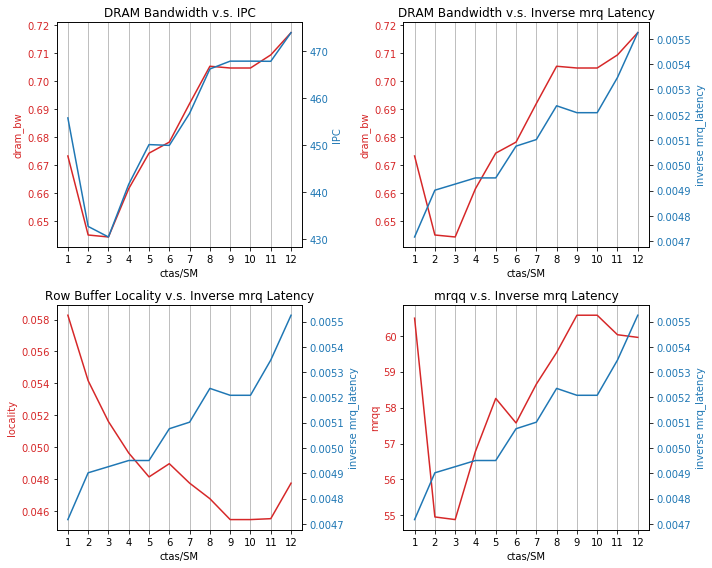

In [13]:
fig, ((ax2, ax3), (ax1, ax4)) = plt.subplots(2, 2, figsize=(10,8))

# FIGURE 1
color = 'tab:red'
ax1.set_xlabel('ctas/SM')
# ax1.set_ylabel('dram_bw', color=color)
# ax1.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
# ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('locality', color=color)
ax1.plot(l_basic['CTA/SM'], l_basic['avg_row_locality'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('performance', color=color)  # we already handled the x-label with ax1
# ax2.plot(l_basic['CTA/SM'], 1/l_basic['runtime'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
ax1a.set_ylabel('inverse mrq_latency', color=color)
ax1a.plot(l_basic['CTA/SM'], 1/l_basic['avg_mrq_latency'], color=color)
ax1a.tick_params(axis='y', labelcolor=color)

ax1.set_title('Row Buffer Locality v.s. Inverse mrq Latency')
ax1.grid(True, axis='x')
ax1.set_xticks(np.arange(1,13,1))

# FIGURE 2
color = 'tab:red'
ax2.set_xlabel('ctas/SM')
ax2.set_ylabel('dram_bw', color=color)
ax2.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2a = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2a.set_ylabel('IPC', color=color)  # we already handled the x-label with ax1
# ax2a.plot(l_basic['CTA/SM'], ldf['instructions'].div(l_basic['runtime']), color=color)
ax2a.plot(l_basic['CTA/SM'], l_basic['instructions']/l_basic['runtime'], color=color)
ax2a.tick_params(axis='y', labelcolor=color)

ax2.set_title('DRAM Bandwidth v.s. IPC')
ax2.grid(True, axis='x')
ax2.set_xticks(np.arange(1,13,1))

# FIGURE 3
color = 'tab:red'
ax3.set_xlabel('ctas/SM')
ax3.set_ylabel('dram_bw', color=color)
ax3.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax3a = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3a.set_ylabel('inverse mrq_latency', color=color)  # we already handled the x-label with ax1
# ax2a.plot(l_basic['CTA/SM'], ldf['instructions'].div(l_basic['runtime']), color=color)
ax3a.plot(l_basic['CTA/SM'], 1/l_basic['avg_mrq_latency'], color=color)
ax3a.tick_params(axis='y', labelcolor=color)

ax3.set_title('DRAM Bandwidth v.s. Inverse mrq Latency')
ax3.grid(True, axis='x')
ax3.set_xticks(np.arange(1,13,1))

# FIGURE 4
color = 'tab:red'
ax4.set_xlabel('ctas/SM')
ax4.set_ylabel('mrqq', color=color)
ax4.plot(l_basic['CTA/SM'], l_basic['avg_mrqq'] , color=color)
ax4.tick_params(axis='y', labelcolor=color)

ax4a = ax4.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4a.set_ylabel('inverse mrq_latency', color=color)  # we already handled the x-label with ax1
# ax2a.plot(l_basic['CTA/SM'], ldf['instructions'].div(l_basic['runtime']), color=color)
ax4a.plot(l_basic['CTA/SM'], 1/l_basic['avg_mrq_latency'], color=color)
ax4a.tick_params(axis='y', labelcolor=color)

ax4.set_title('mrqq v.s. Inverse mrq Latency')
ax4.grid(True, axis='x')
ax4.set_xticks(np.arange(1,13,1))



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observations:
# 1. performance is positively correlated with dram bandwidth utilization
# 2. mrq latency going down might be because as the number of requests increases, 
# the row buffer locality improves??  

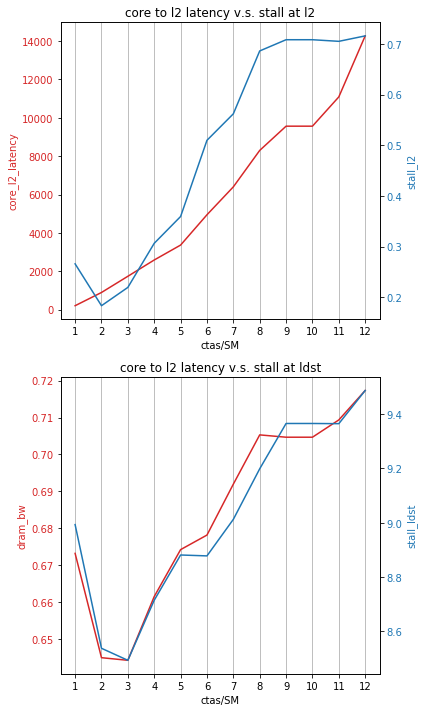

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

# FIGURE 1
color = 'tab:red'
ax1.set_xlabel('ctas/SM')
ax1.set_ylabel('core_l2_latency', color=color)
ax1.plot(l_basic['CTA/SM'], l_basic['avg_core_to_l2'] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1a.set_ylabel('stall_l2', color=color)  # we already handled the x-label with ax1
ax1a.plot(l_basic['CTA/SM'], l_basic['stall_l2'], color=color)
ax1a.tick_params(axis='y', labelcolor=color)

ax1.set_title('core to l2 latency v.s. stall at l2')
ax1.grid(True, axis='x')
ax1.set_xticks(np.arange(1,13,1))

# FIGURE 2
color = 'tab:red'
ax2.set_xlabel('ctas/SM')
ax2.set_ylabel('dram_bw', color=color)
ax2.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2a = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2a.set_ylabel('stall_ldst', color=color)  # we already handled the x-label with ax1
ax2a.plot(l_basic['CTA/SM'], l_basic['stall_ldst'], color=color)
ax2a.tick_params(axis='y', labelcolor=color)

ax2.set_title('core to l2 latency v.s. stall at ldst')
ax2.grid(True, axis='x')
ax2.set_xticks(np.arange(1,13,1))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observation: 
# core to l2 latency isn't really correlated with stalls at L2/LdST unit, 
# maybe interconnect is the problem??
# Gennady:
# this curve is basically perfectly linear -> should never happen on a simulator
# the interconnect should follow queueing delay (non-linear increase in latency)
# in reality, the performance of the interconnect should never be a bottleneck (provisioned enough)
# so that real applications are either compute bound or memory bound

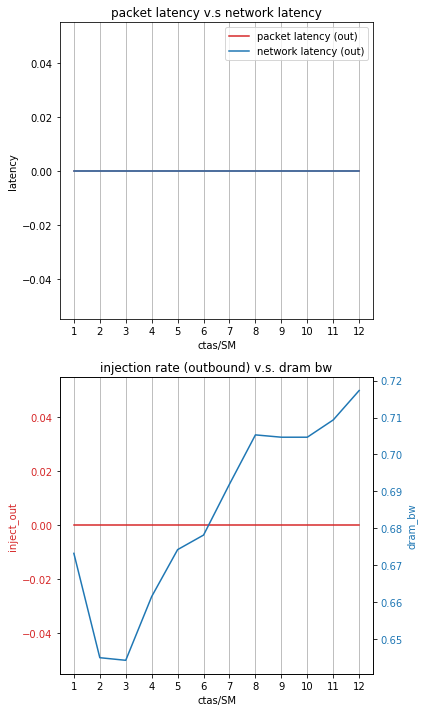

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

# FIGURE 1
color = 'tab:red'
ax1.set_xlabel('ctas/SM')
ax1.set_ylabel('latency')
ax1.plot(l_basic['CTA/SM'], l_basic['packet_lat_out'] , color=color)
ax1.tick_params(axis='y')

#ax1a = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
#ax1.set_ylabel('network_lat_out', color=color)  # we already handled the x-label with ax1
ax1.plot(l_basic['CTA/SM'], l_basic['network_lat_out'], color=color)
#ax1a.tick_params(axis='y', labelcolor=color)
ax1.legend(['packet latency (out)', 'network latency (out)'])

ax1.set_title('packet latency v.s network latency')
ax1.grid(True, axis='x')
ax1.set_xticks(np.arange(1,13,1))

# FIGURE 2
color = 'tab:red'
ax2.set_xlabel('ctas/SM')
ax2.set_ylabel('inject_out', color=color)
ax2.plot(l_basic['CTA/SM'], l_basic['inject_out'] , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2a = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2a.set_ylabel('dram_bw', color=color)  # we already handled the x-label with ax1
ax2a.plot(l_basic['CTA/SM'], l_basic['avg_dram_bw'], color=color)
ax2a.tick_params(axis='y', labelcolor=color)

ax2.set_title('injection rate (outbound) v.s. dram bw')
ax2.grid(True, axis='x')
ax2.set_xticks(np.arange(1,13,1))


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observation: 
# injection rate to the interconnect is correlated with the dram bandwidth util?????????????

## LBM (NOC buffer changes)

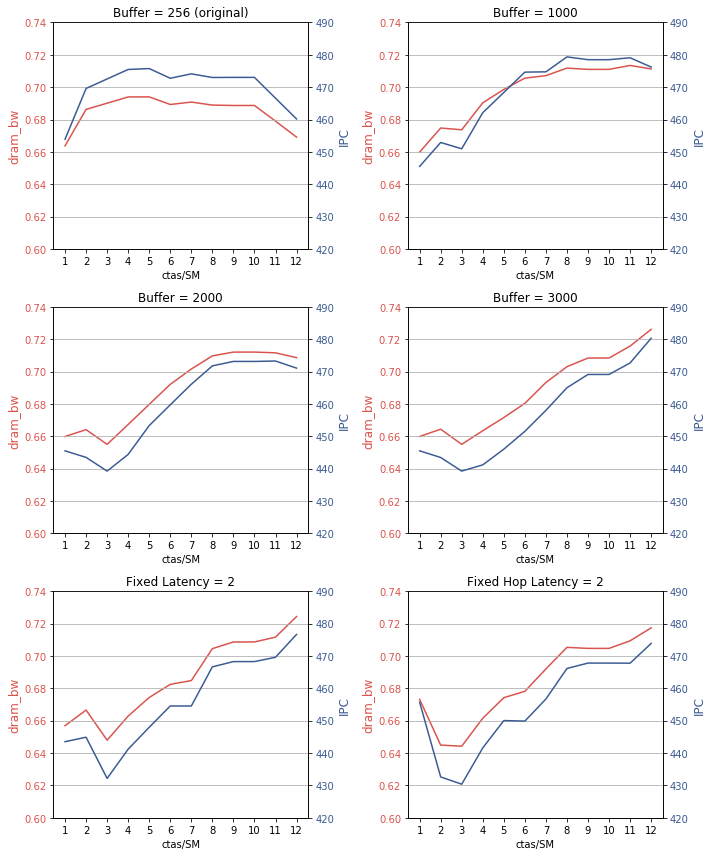

In [32]:
# current_palette = sns.color_palette()

# Dram BW changes as the NOC configs change
def extract_df(filename):
    _df = pd.read_csv(filename)
    _df['CTA/SM'] = _df['config'].apply(lambda x: x[7:-3]).astype(int)
    _df['avg_dram_bw'] = _df['dram_bw'].transform(avg_array)
    _df['IPC'] = _df['instructions'] / _df['runtime']
    _df['avg_row_locality'] = _df['row_buffer_locality'].transform(avg_array)

    return _df[['CTA/SM', 
                'avg_dram_bw', 'avg_row_locality',
                'IPC',
                  ]].sort_values(by=['CTA/SM'])

def draw_fig(df_in, axis, title):
    color_red = sns.xkcd_rgb["pale red"]
    color_blue = sns.xkcd_rgb["denim blue"]

    axis.set_xlabel('ctas/SM')
    axis.set_ylabel('dram_bw', color=color_red, fontsize=12)
    axis.plot(df_in['CTA/SM'], df_in['avg_dram_bw'], color=color_red)
    axis.tick_params(axis='y', labelcolor=color_red)
    axis.set_ylim([0.6, 0.74])
    axis.set_axisbelow(True)

    axis1 = axis.twinx()  # instantiate a second axes that shares the same x-axis

    axis1.set_ylabel('IPC', color=color_blue, fontsize=12)
    axis1.plot(df_in['CTA/SM'], df_in['IPC'], color=color_blue)
    axis1.tick_params(axis='y', labelcolor=color_blue)
    axis1.set_ylim([420, 490])

    axis1.set_title(title)
    axis1.set_xticks(df_in['CTA/SM'])
    axis1.set_axisbelow(True)
    axis1.grid(True)
   

df_256 = extract_df('lbm2.csv')
df_1000 = extract_df('lbm-large.csv')
df_2000 = extract_df('lbm-xl.csv')
df_3000 = extract_df('lbm-xxl.csv')
df_fixed = extract_df('lbm-fixed.csv')
df_hop = extract_df('lbm-hop.csv')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,12))

draw_fig(df_256, ax1, 'Buffer = 256 (original)')
draw_fig(df_1000, ax2, 'Buffer = 1000')
draw_fig(df_2000, ax3, 'Buffer = 2000')
draw_fig(df_3000, ax4, 'Buffer = 3000')
draw_fig(df_fixed, ax5, 'Fixed Latency = 2')
draw_fig(df_hop, ax6, 'Fixed Hop Latency = 2')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('buffers.pdf')
# plt.show()

# Observation:
# 1. the trends of DRAM bandwidth and IPC are very correlated in all NOC configs
# 2. Even though IPC reaches max when CTA/SM is less than 12 when the buffer is small (256), most of the CTA/SM
# configs can achieve a high IPC compared with other NOC configs
# 3. When the buffer size is medium (1000, 20000), the trend in IPC starts to plateu around CTA/SM = 8. But when
# the buffer size is large (3000), IPC continues to rise beyond 8 CTA/SM